In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

from helpers import IFMRHandler, PopHandler, AgeMS, IMFHandler
from jjmodel.iof import tab_reader
from jjmodel.input_ import p, a, inp



Parameter file(s) : ok.
Number of parameters =  66 , among them technical =  7

 p(run_mode=0, out_dir='tutorial1', out_mode=1, nprocess=4, Rsun=8.2, zsun=20, zmax=2000, dz=2, sigmad=29.3, sigmat=4.9, sigmag1=2.0, sigmag2=11.0, sigmadh=51.9, sigmash=0.47, td1=0, td2=7.8, dzeta=0.8, eta=5.6, pkey=1, tt1=0.1, tt2=4, gamma=2, beta=3.5, imfkey=0, a0=1.31, a1=1.5, a2=2.88, a3=2.28, m0=0.49, m1=1.43, m2=6.0, dFeHdt=0, n_FeHdt=1, fehkey=0, FeHd0=-0.7, FeHdp=0.29, rd=0.34, q=-0.72, FeHt0=-0.94, FeHtp=0.04, rt=0.77, t0=0.97, FeHsh=-1.5, dFeHsh=0.4, n_FeHsh=5, alpha=0.375, sige=26.0, sigt=45, sigdh=140, sigsh=100, sigmap=array([3.5, 1.3]), tpk=array([10. , 12.5]), dtp=array([0.7 , 0.25]), sigp=array([26.3, 12.6]))

Parameters checked: 0 Reminders, 0 Warnings, 0 Errors.

Configuration finished:  0h 0m 0.01s


In [2]:
pop_handler = PopHandler(p,a,inp)
ifmr = IFMRHandler()

In [3]:
mode_iso = 'Padova'
FeH_scatter = 0.07
Nmet_dt = 7

imf_handler = IMFHandler(p)
imf_ref, (mass_binsc, IMF_ref) = imf_handler.create_reference_imf()


# Create population tables
pop_kwargs = {'FeH_scatter':FeH_scatter,
              'Nmet_dt':Nmet_dt,
              'Nmet_sh':Nmet_dt
              }

pop_tabs_ref = pop_handler.create_reference_pop_tabs(imf_ref, mode_iso, wd='ms+wd', **pop_kwargs) 



Stellar population synthesis for R = 8.2 kpc:
Warning. Some of modeled metallicities (halo) are outside of Padova metallicity range [-2.2,0.5], i.e., the adopted best isochrones may be not representative.
	thin disk	thick disk	halo


In [3]:
labels = ['d','t','sh']

pop_tabs = {}
for label in labels:
    pop_tab = tab_reader('ssp',p,a.T,tab=True,mode=label,R=p.Rsun)
    pop_tabs[label] = pop_tab

pop_tabs['d'].keys()

['N',
 'age',
 'FeH',
 'Mini',
 'Mf',
 'logL',
 'logT',
 'logg',
 'phase',
 'G_EDR3',
 'GBP_EDR3',
 'GRP_EDR3',
 'age_WD',
 'disk_label']

In [4]:

ind_da, ind_db = pop_handler.get_wd_idx(pop_tabs)
ind_wd = {label: np.concatenate((ind_da[label],ind_db[label]),axis=-1) for label in labels}

In [5]:

for label in labels:
    pop_tabs[label]['Mini_ks'] = [np.nan for _ in np.arange(len(pop_tabs[label]['Mini']))] # new column
    pop_tabs[label]['sigma_Mini_ks'] = [np.nan for _ in np.arange(len(pop_tabs[label]['Mini']))] # new column

    Mini, sigma_Mini = ifmr.cummings_r(pop_tabs[label]['Mf'][ind_wd[label]],calibration='padova')
    
    pop_tabs[label]['Mini_ks'][ind_wd[label]] = Mini
    pop_tabs[label]['sigma_Mini_ks'][ind_wd[label]] = sigma_Mini

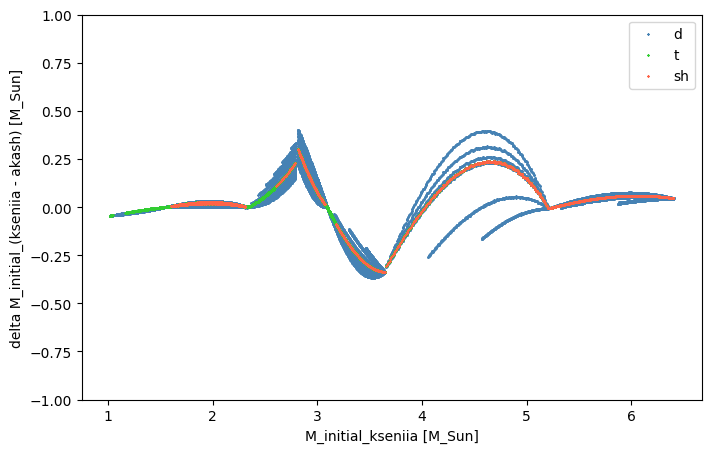

In [7]:
colors = ['steelblue','limegreen','tomato']

fig, ax = plt.subplots(figsize=(8,5))

for l,color in zip(labels,colors):
    mini_diff = (pop_tabs[l]['Mini_ks'] - pop_tabs[l]['Mini'])
    ax.scatter(pop_tabs[l]['Mini_ks'],mini_diff*pop_tabs[l]['Mini_ks'],marker='x',s=1,c=color,label=l)

    ax.set_xlabel('M_initial_kseniia [M_Sun]')
    ax.set_ylabel('delta M_initial_(kseniia - akash) [M_Sun]')

    ax.set_ylim(-1,1)

plt.legend(loc=1)
#plt.savefig('Mini_check1_mist.png')



In [8]:
param_file = 'MS_lifetime_padova/analysis/fit_v1_Mbr1.2/tau_ms_params_v1_Mbr1.2.txt'

agefit = AgeMS(param_file=param_file)

for label in labels:
    pop_tabs[label]['age_MS_ks'] = [np.nan for _ in np.arange(len(pop_tabs[label]['Mini']))] # new column
    
    age_MS = [agefit.get_age_ms(mini,feh=met) for mini,met in zip(pop_tabs[label]['Mini'][ind_wd[label]],
                                                                  pop_tabs[label]['FeH'][ind_wd[label]])]
    pop_tabs[label]['age_MS_ks'][ind_wd[label]] = age_MS
    pop_tabs[label]['age_ks'] = pop_tabs[label]['age_MS_ks'] + pop_tabs[label]['age_WD']


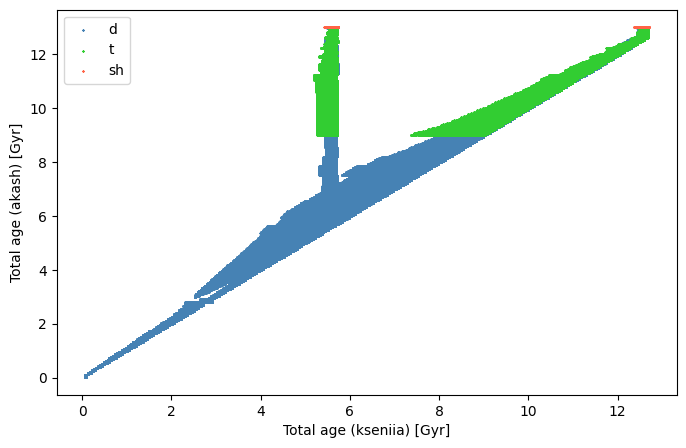

In [9]:
fig, ax = plt.subplots(figsize=(8,5))

for l,color in zip(labels,colors):
    ax.scatter(pop_tabs[l]['age_ks'][ind_wd[l]],
               pop_tabs[l]['age'][ind_wd[l]],marker='x',s=1,c=color,label=l)

    ax.set_xlabel('Total age (kseniia) [Gyr]')
    ax.set_ylabel('Total age (akash) [Gyr]')

    #ax.set_ylim(-4,1)

plt.legend(loc=2)

In [ ]:
# add IFMR scatter kernel to calculation of N_wd
# update N_wd given new IFMR (FeH - reference column)
# add cooling delay as another parameter for updating N_wd
# collect everything together (wd parameters for mcmc to posterior)

# clean up all code